# EDA and Cleaning

### Reading in the training dataset and looking for missing values and corrupt dtypes

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
pd.options.display.max_rows = 4000 

In [4]:
data_train = pd.read_csv('./../datasets/train.csv')
data_test = pd.read_csv('./../datasets/test.csv')

In [5]:
data_train.shape

(2051, 90)

In [6]:
data_train.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

In [7]:
# Function to rename all columns to lowercase
def rename_to_snakecase(df_called):
    import pandas as pd
    df_called.rename(columns={item: '_'.join(item.lower().split()) for item in df_called.columns}, inplace = True)
    return df_called

In [8]:
# Function called to rename columns
rename_to_snakecase(data_train);
rename_to_snakecase(data_test);

### Changing nan values to appropriate values wherever possible based on data dictionary

In [9]:
# data_test.isna().sum()

In [10]:
# All these have 'NA' replaced by NaN, changing it to NO to avoid problem while saving
to_drop = list(data_train.columns[data_train.isna().mean() >= 0.80])
data_train.loc[:,to_drop] = data_train.loc[:,to_drop].replace({np.nan:'NONE'})

for item in to_drop:
    data_train[item+'_true'] = data_train[item].map(lambda x: 0 if x=='NONE' else 1)
    
to_drop = list(data_test.columns[data_test.isna().mean() >= 0.80])
data_test.loc[:,to_drop] = data_test.loc[:,to_drop].replace({np.nan:'NONE'})

for item in to_drop:
    data_test[item+'_true'] = data_test[item].map(lambda x: 0 if x=='NONE' else 1)

In [11]:
# All columns with NaN in them
# These columns seem to related to other columns

columns_with_nan = data_train.isna().mean()[data_train.isna().mean() > 0.0].index
bsmt_cols_with_nan = []
garage_cols_with_nan = []
other_cols_with_nan = []
for item in columns_with_nan:
    if ('bsmt' in item):
        bsmt_cols_with_nan.append(item)
    elif ('garage' in item):
        garage_cols_with_nan.append(item)
    else:
        other_cols_with_nan.append(item)        

In [12]:
# All columns with NaN that are basement related

bsmt_cols_with_nan

[]

In [13]:
# All columns with NaN that are garage related

garage_cols_with_nan

[]

In [14]:
# All columns that are not hugely dependent on other columns
# 'fireplace_qu' is related 'fireplaces'
# 'mas_vnr_type' and 'mas_vnr_area' are related 
# There is 'lot_frontage'

other_cols_with_nan

[]

#### Start with cleaning columns in `other_cols_with_nan`

###### 1) `lot_frontage`

###### Understanding lot related dict

`Lot Shape` (Ordinal): General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
`Lot Config` (Nominal): Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

In [15]:
# Added a new column to check whether the lot_frontage is known to exist or not

data_train['lot_frontage_true'] = (data_train.loc[:,'lot_frontage'].notna()).map(lambda x: float(x))
data_train['lot_frontage'] = data_train['lot_frontage'].replace({np.nan: 0})
data_test['lot_frontage_true'] = (data_test.loc[:,'lot_frontage'].notna()).map(lambda x: float(x))
data_test['lot_frontage'] = data_test['lot_frontage'].replace({np.nan: 0})

###### 2) `fireplace_qu`

We notice that the `fireplace_qu` is NaN for those house with no `fireplaces`
Make a new column on whether fireplace exists as `fireplace_true`

In [16]:
data_train['fireplace_qu'] = data_train['fireplace_qu'].replace({np.nan:0})
data_test['fireplace_qu'] = data_test['fireplace_qu'].replace({np.nan:0})

###### 3) `mas_vnr_type` and `mas_vnr_area`

In [17]:
mask = data_train['mas_vnr_area'].isna()
list_of_idx = list(data_train[mask].index)
data_train.loc[list_of_idx,'mas_vnr_area'] = 0
mask = data_train['mas_vnr_type'].isna()
list_of_idx = list(data_train[mask].index)
data_train.loc[list_of_idx,'mas_vnr_type'] = data_train.loc[list_of_idx,'mas_vnr_type'].replace({np.nan : 'unknown'})

In [18]:
mask = data_test['mas_vnr_area'].isna()
list_of_idx = list(data_test[mask].index)
data_test.loc[list_of_idx,'mas_vnr_area'] = 0
mask = data_test['mas_vnr_type'].isna()
list_of_idx = list(data_test[mask].index)
data_test.loc[list_of_idx,'mas_vnr_type'] = data_test.loc[list_of_idx,'mas_vnr_type'].replace({np.nan : 'unknown'})

In [19]:
data_train['mas_vnr_true'] = data_train['mas_vnr_type'].map(lambda x: 0 if x=='unknown' else 1)
data_test['mas_vnr_true'] = data_test['mas_vnr_type'].map(lambda x: 0 if x=='unknown' else 1)

#### Cleaning columns in `garage_cols_with_nan`

`garage_type`:

       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
           NA   No Garage

`garage_qual`:

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

`garage_cond`:

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

`garage_yr_blt`, `garage_finish`, `garage_area`

It would appear that the no garage condition is interpreted as nan

In [20]:
for item in ['garage_cond','garage_qual','garage_type']:
    data_train[item] = data_train[item].replace({np.nan : 'NONE'})
    data_test[item] = data_test[item].replace({np.nan : 'NONE'})

In [21]:
mask = (data_train['garage_cond'] == 'NONE') & (data_train['garage_qual'] == 'NONE') & (data_train['garage_type'] == 'NONE')
list_to_change = ['garage_yr_blt','garage_finish']
data_train.loc[mask,list_to_change] = data_train.loc[mask,list_to_change].replace({np.nan : 0})

mask = (data_test['garage_cond'] == 'NONE') & (data_test['garage_qual'] == 'NONE') & (data_test['garage_type'] == 'NONE')
list_to_change = ['garage_yr_blt','garage_finish']
data_test.loc[mask,list_to_change] = data_test.loc[mask,list_to_change].replace({np.nan : 0})

In [22]:
mask = data_train['garage_cond'] == 'NONE'
data_train.loc[mask,'garage_cars'] = data_train.loc[mask,'garage_cars'].replace({np.nan:0})
data_train.loc[mask,'garage_area'] = data_train.loc[mask,'garage_area'].replace({np.nan:0})

mask = (data_test['garage_cond'] == 'NONE') & (data_test['garage_qual'] == 'NONE') & (data_test['garage_type'] == 'NONE')
list_to_change = ['garage_yr_blt','garage_finish']
data_test.loc[mask,list_to_change] = data_test.loc[mask,list_to_change].replace({np.nan : 0})

In [23]:
data_train.loc[data_train['garage_yr_blt'].isna(),['garage_yr_blt','garage_finish']] = 0
data_test.loc[data_test['garage_yr_blt'].isna(),['garage_yr_blt','garage_finish']] = 0

In [24]:
data_train['garage_true'] = data_train['garage_cond'].map(lambda x: 0 if x=='NO' else 1)
data_test['garage_true'] = data_test['garage_cond'].map(lambda x: 0 if x=='NO' else 1)

#### Cleaning columns in `bsmt_cols_with_nan`

`bsmt_qual`

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

`bsmt_cond`, `bsmt_exposure`, `bsmtfin_type_1`, `bsmtfin_sf_1`, `bsmtfin_type_2`, `bsmtfin_sf_2`, `bsmt_unf_sf`, `total_bsmt_sf`, `bsmt_full_bath`, `bsmt_half_bath`, `bsmt_total_bath`

In [25]:
data_train['bsmt_qual'] = data_train['bsmt_qual'].replace({np.nan:'NONE'})
data_test['bsmt_qual'] = data_test['bsmt_qual'].replace({np.nan:'NONE'})

In [26]:
for item in data_train.loc[data_train['bsmt_qual'] == 'NONE', bsmt_cols_with_nan].select_dtypes(include = 'object').columns:
    data_train[item] = data_train[item].replace({np.nan : 'NONE'})
    
for item in data_test.loc[data_test['bsmt_qual'] == 'NONE', bsmt_cols_with_nan].select_dtypes(include = 'object').columns:
    data_test[item] = data_test[item].replace({np.nan : 'NONE'})

In [27]:
for item in data_train.loc[data_train['bsmt_qual'] == 'NONE', bsmt_cols_with_nan].select_dtypes(exclude = 'object').columns:
    data_train[item] = data_train[item].replace({np.nan : 0})
    
for item in data_test.loc[data_test['bsmt_qual'] == 'NONE', bsmt_cols_with_nan].select_dtypes(exclude = 'object').columns:
    data_test[item] = data_test[item].replace({np.nan : 0})

In [28]:
data_test['bsmt_true'] = data_test['bsmt_cond'].map(lambda x: 0 if x=='NONE' else 1)

In [29]:
data_test['electrical'] = data_test['electrical'].replace({np.nan:'NONE'})

### Writing the the cleaned file to another csv

In [30]:
data_train.to_csv('../datasets/cleaned_train_data.csv', index=False)
data_test.to_csv('../datasets/cleaned_test_data.csv', index=False)

### Plot some variables to visualize their correlations

In [31]:
data_train.corr();

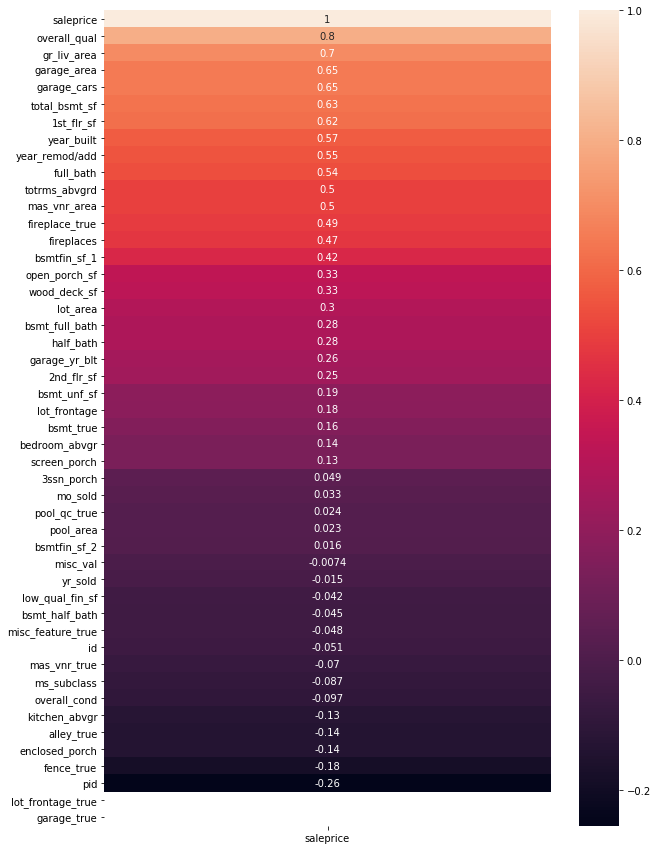

In [32]:
plt.figure(figsize=(10,15))
sns.heatmap(data_train.corr()[['saleprice']].sort_values(by='saleprice', ascending = False),annot=True, );

In [33]:
def obtain_list_important_correlations(df_called, variable_dependent, corr_percent):
    mask = (df_called.corr()[[variable_dependent]].abs().sort_values(by=variable_dependent, ascending = False) > corr_percent)
    list_to_return = list(df_called.corr()[[variable_dependent]].abs().sort_values(by=variable_dependent, ascending = False)[mask].index)
    list_to_return.remove(variable_dependent)
    return list_to_return

In [34]:
features = obtain_list_important_correlations(data_train, 'saleprice', 0.10)

In [35]:
def scatter_plot(df_called, variable_dependent, list_of_features):
    for item in list_of_features:
        plt.figure(figsize=(7,7))
        plt.scatter(df_called[item], df_called[variable_dependent])
        plt.ylabel(variable_dependent)
        plt.xlabel(item)
        plt.title(variable_dependent +' vs '+ item );

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


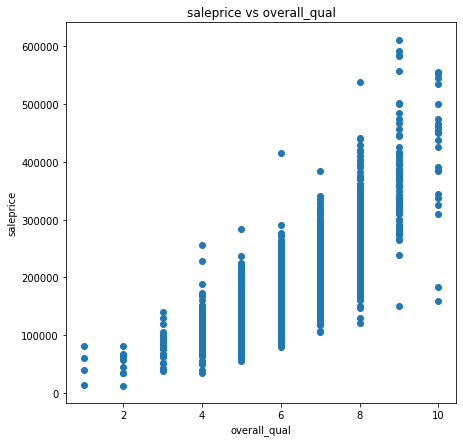

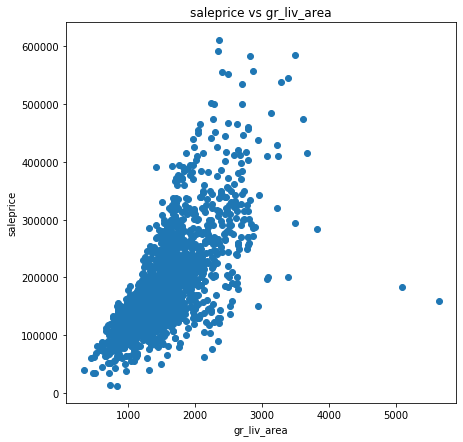

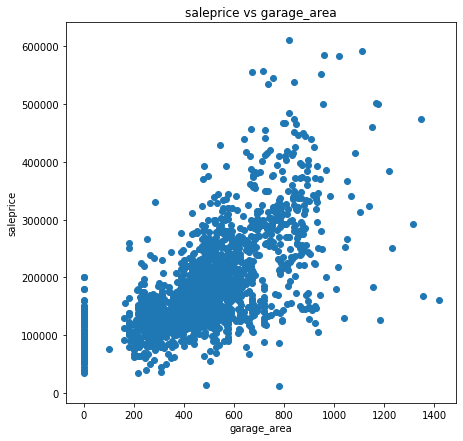

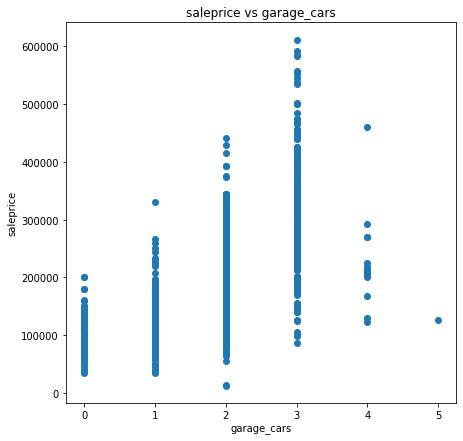

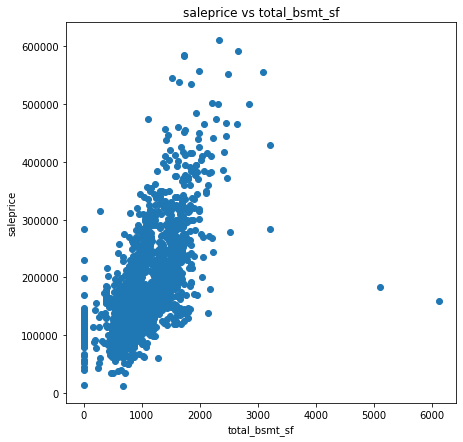

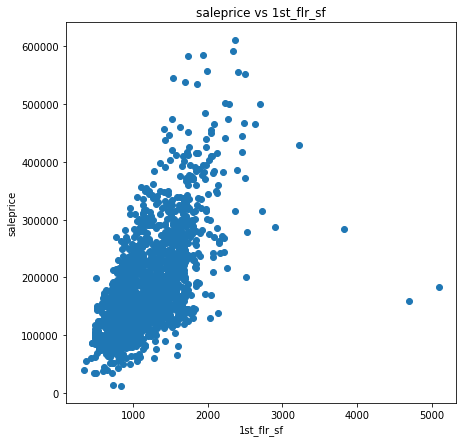

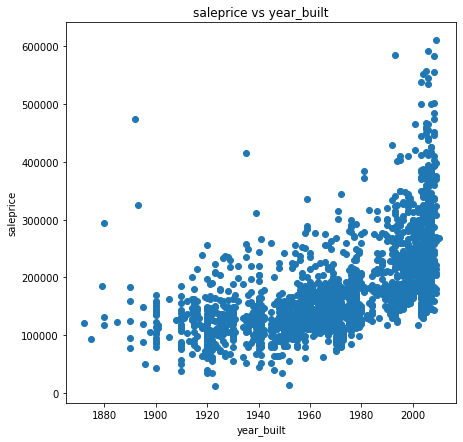

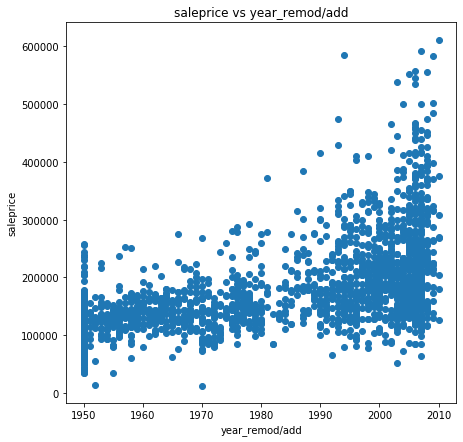

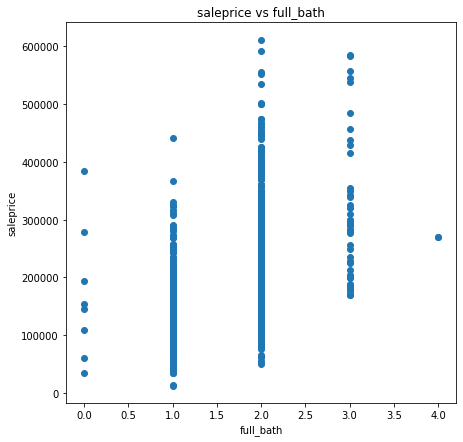

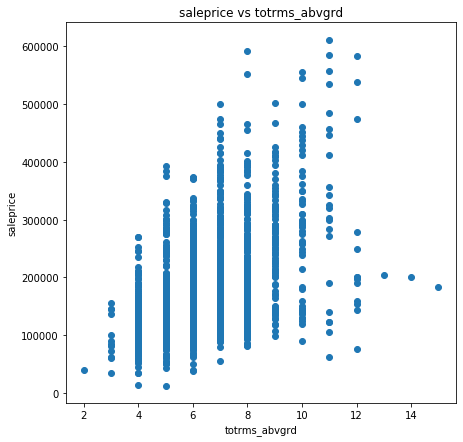

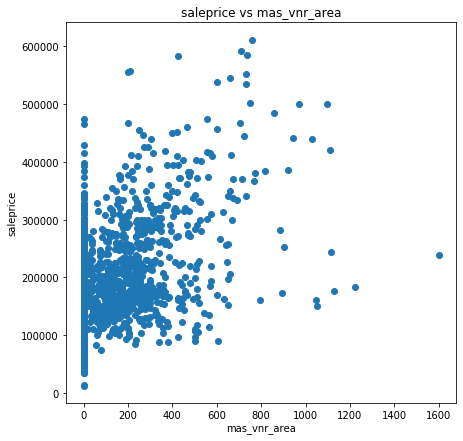

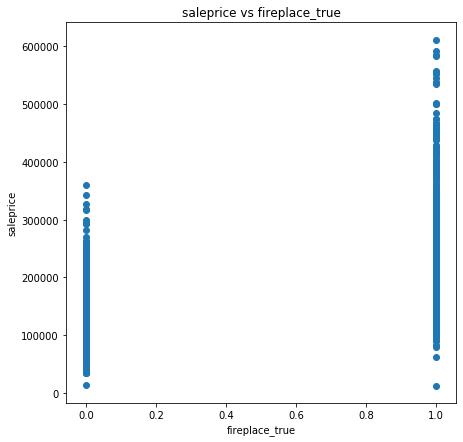

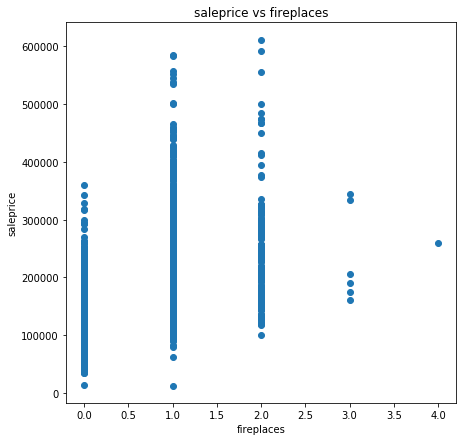

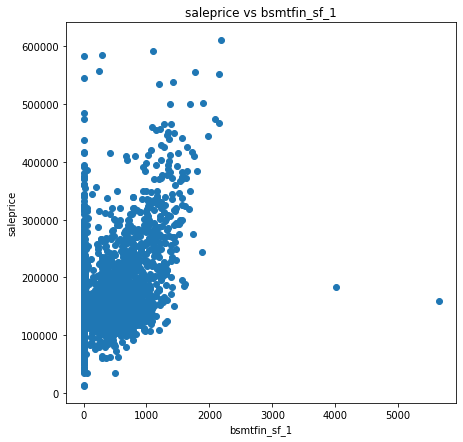

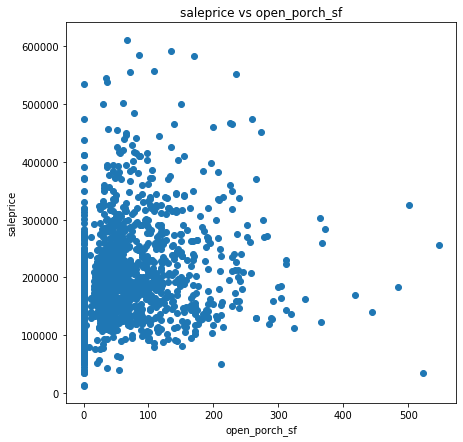

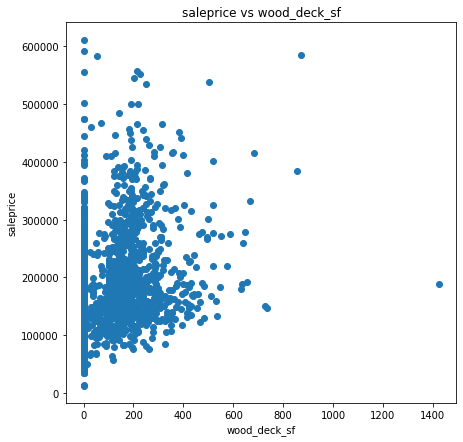

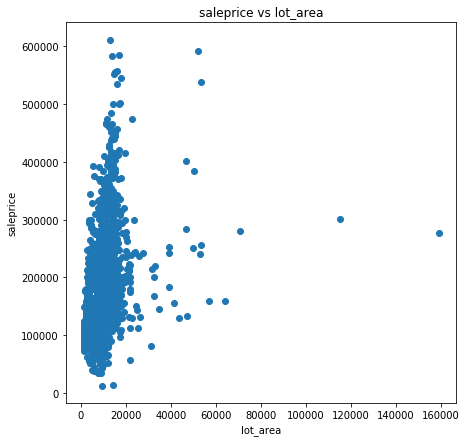

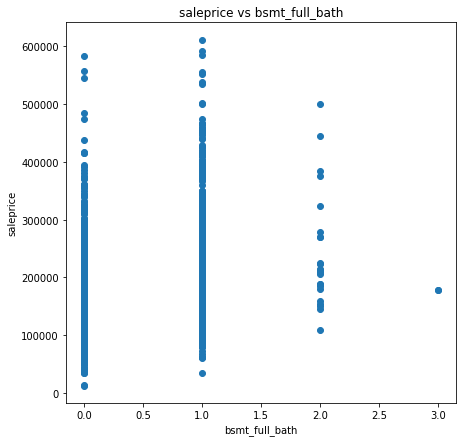

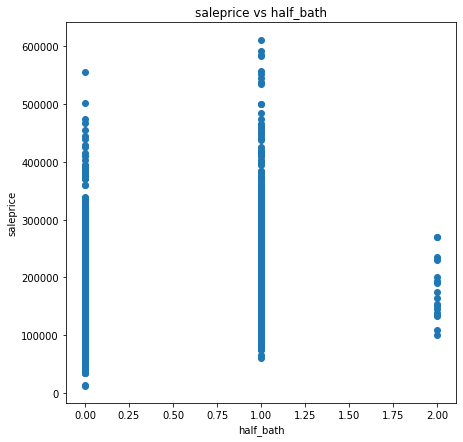

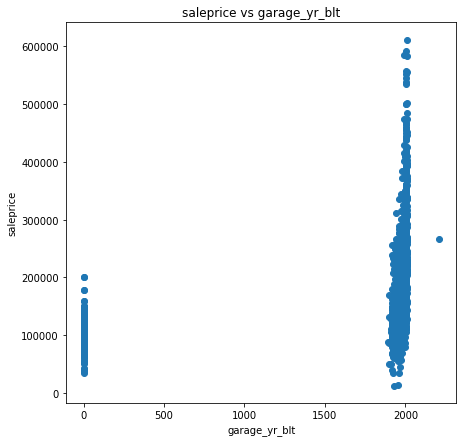

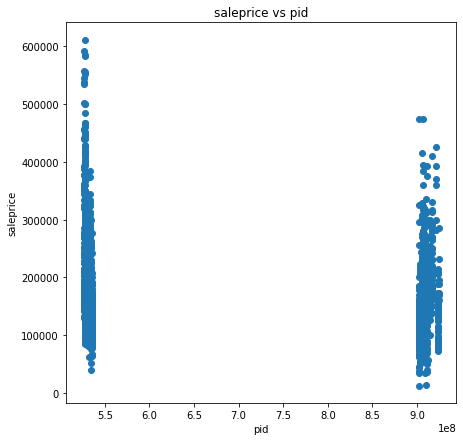

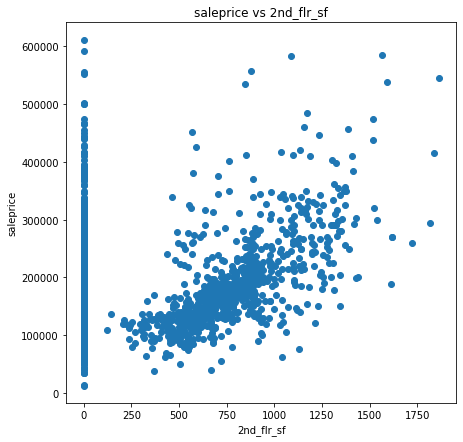

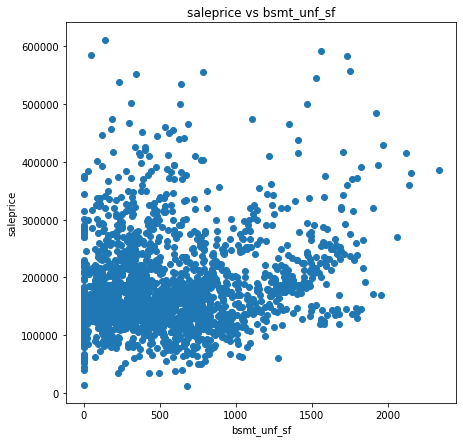

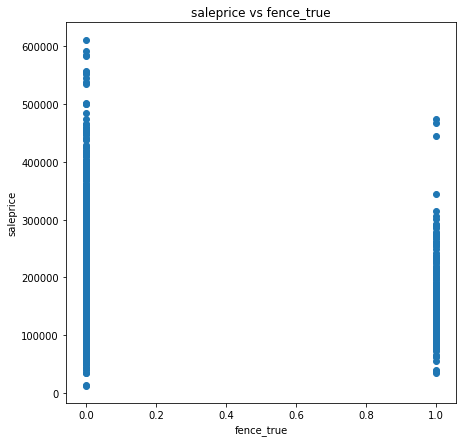

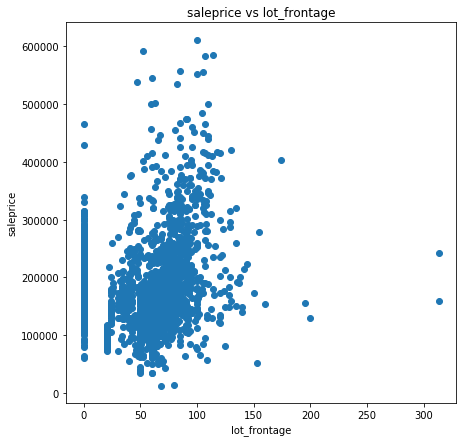

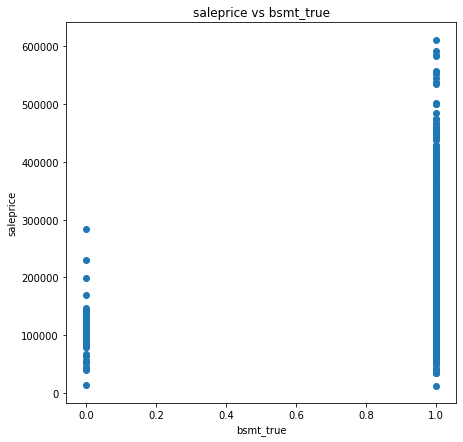

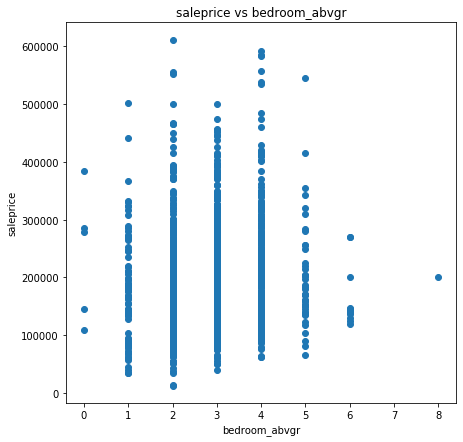

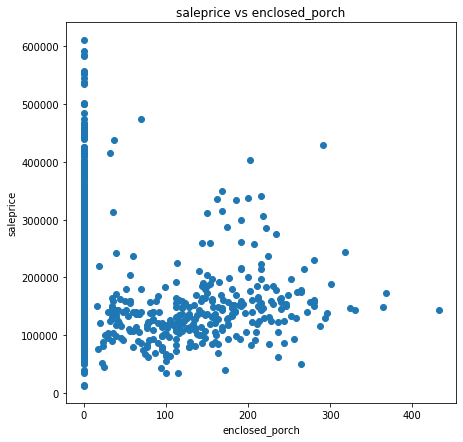

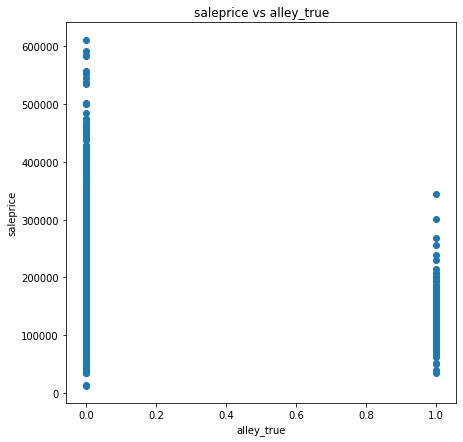

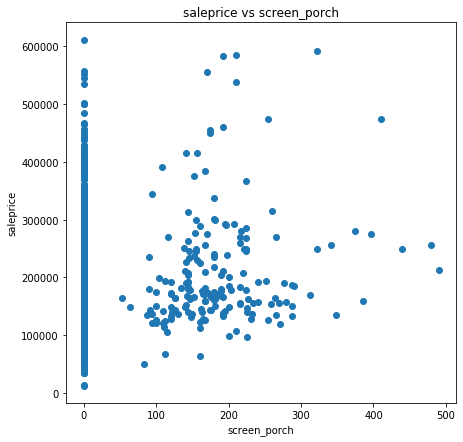

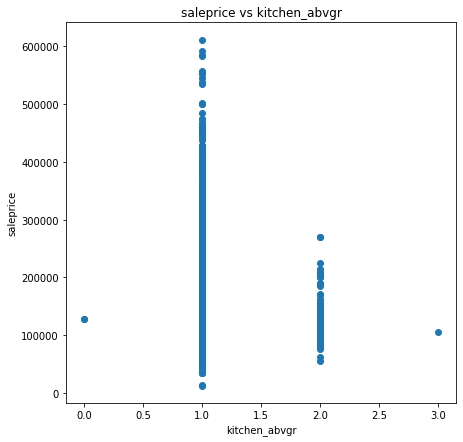

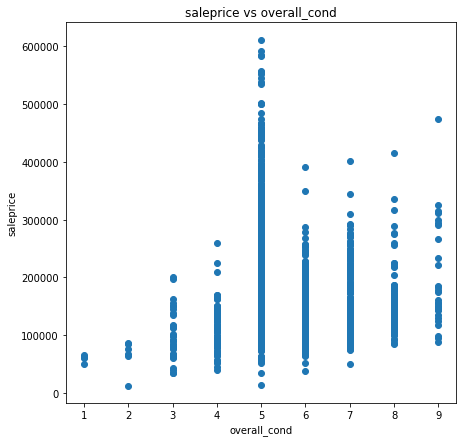

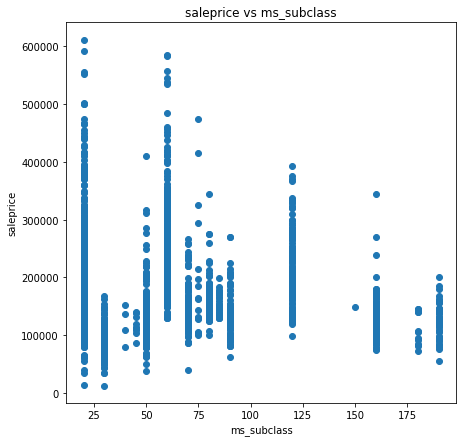

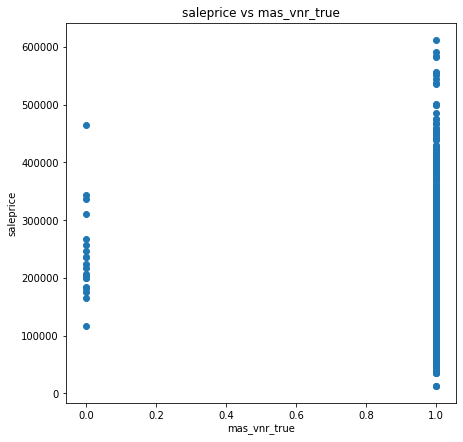

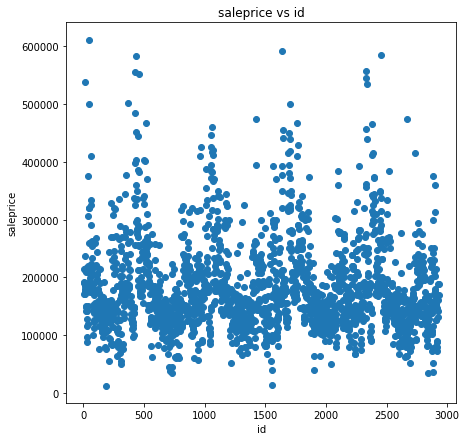

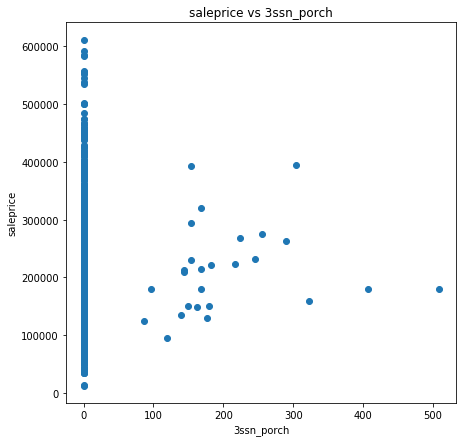

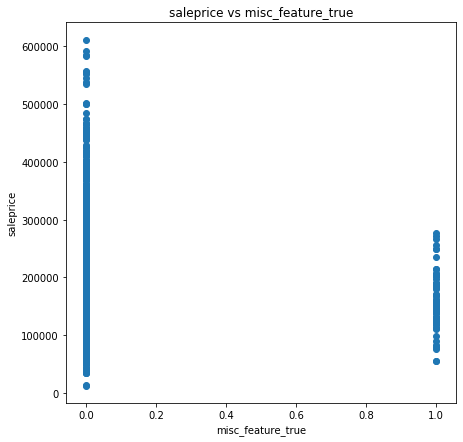

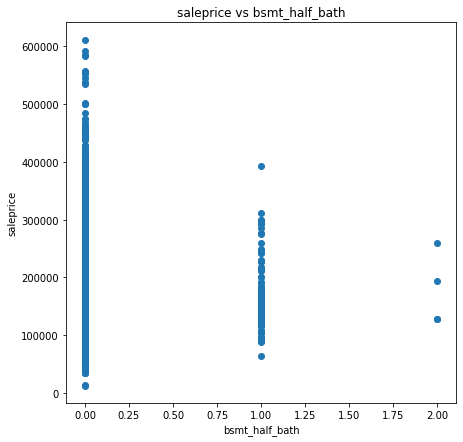

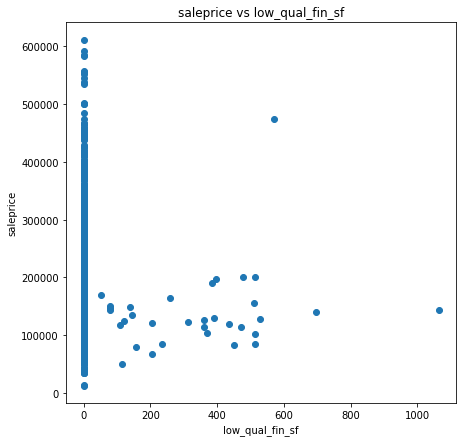

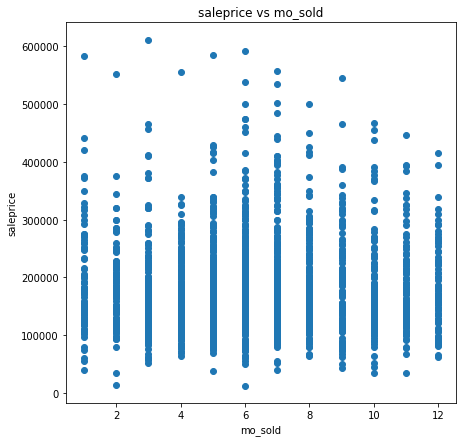

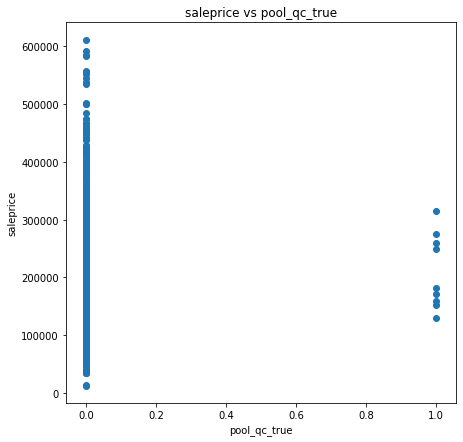

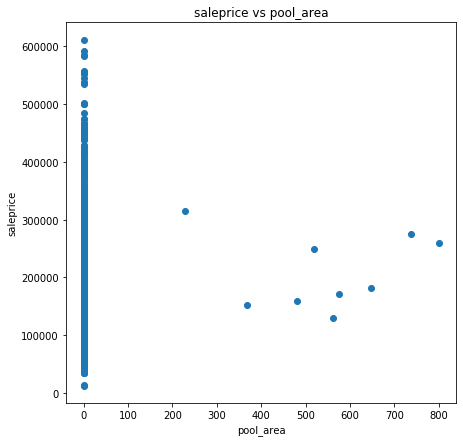

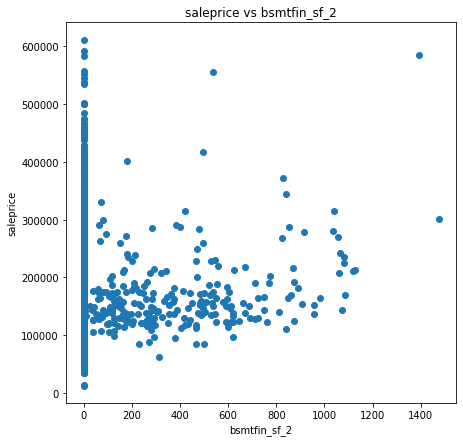

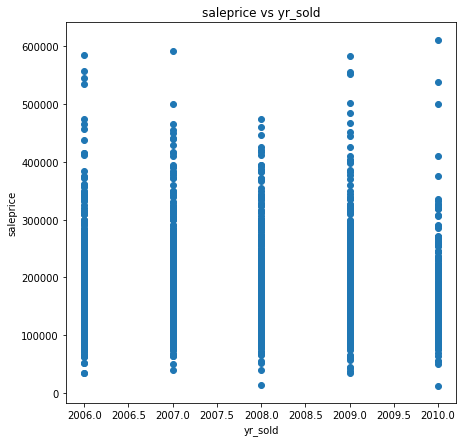

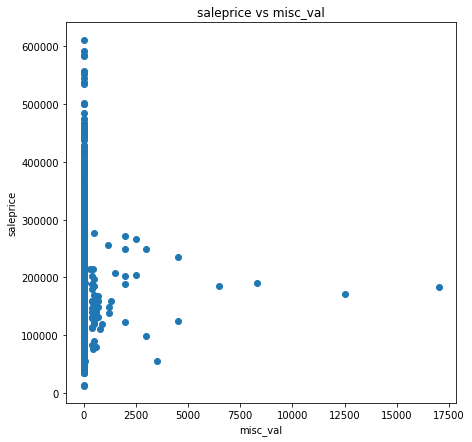

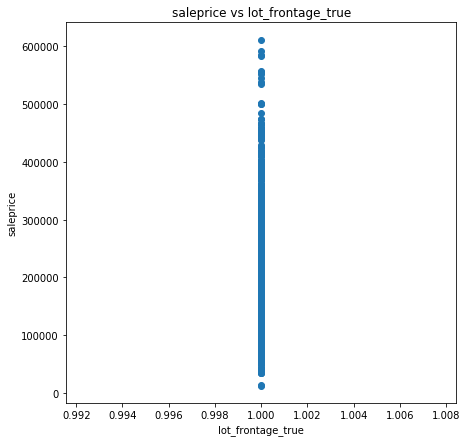

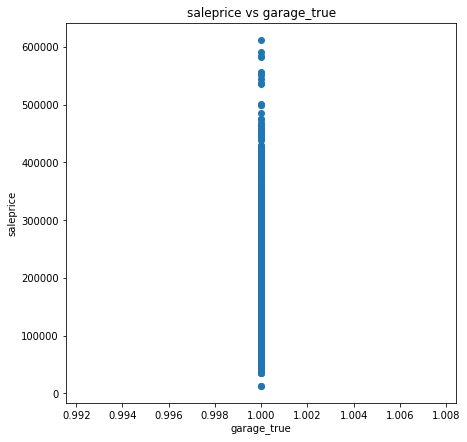

In [36]:
scatter_plot(data_train, 'saleprice', features);

In [37]:
data_train.head().T

,0,1,2,3,4
id,109,544,153,318,255
pid,533352170,531379050,535304180,916386060,906425045
ms_subclass,60,60,20,60,50
ms_zoning,RL,RL,RL,RL,RL
lot_frontage,0,43,68,73,82
lot_area,13517,11492,7922,9802,14235
street,Pave,Pave,Pave,Pave,Pave
alley,NONE,NONE,NONE,NONE,NONE
lot_shape,IR1,IR1,Reg,Reg,IR1
land_contour,Lvl,Lvl,Lvl,Lvl,Lvl
